In [24]:
%matplotlib inline
from re import DEBUG
from turtle import color
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from warnings import simplefilter
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import WindowsPath
import time
from collections import defaultdict
import re
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import datetime
import pickle

In [25]:
DEBUGGING: bool = False
NUM_EVENT_PER_POS = 100
MAP_SET_PADS_TO_TRIANGLE = defaultdict(
    int,
    {
        frozenset([6, 5, 4]): 1,
        frozenset([4, 5, 3]): 2,
        frozenset([4, 3, 2]): 3,
        frozenset([3, 2, 1]): 4,
        frozenset([6, 8, 5]): 5,
        frozenset([5, 3, 13]): 6,
        frozenset([3, 13, 1]): 7,
        frozenset([8, 5, 10]): 8,
        frozenset([5, 10, 13]): 9,
        frozenset([13, 1, 14]): 10,
        frozenset([8, 9, 10]): 11,
        frozenset([10, 11, 13]): 12,
        frozenset([11, 13, 14]): 13,
        frozenset([9, 10, 11]): 14,
    },
)
max_num_triangle: int = 14
COL_PADS = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14])
UNIT_OF_MEASURE_COL = {
    "pmax": "mV",
    "negpmax": "mV",
    "tmax": "ns",
    "area": "mV $\\cdot$ ns",
    "rms": "mV",
}


In [3]:

dev_df = pd.read_csv(
    "development.csv", header=0, index_col=False
)
dev_df.head()

,x,y,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,200.0,200.0,4.066907,-17.690173,2.847932,0.600000,2.007042,5.409161,-17.721210,4.538778,...,607.109118,-36.282996,583.899899,72.373094,0.374498,614.916861,-39.848523,591.852768,72.331028,0.405595
1,200.0,200.0,5.916801,-4.717111,5.792778,79.765174,1.564535,4.414289,-4.736827,3.720435,...,630.348007,-39.715988,580.042799,71.029155,0.403258,624.950701,-41.266681,586.569646,71.089058,0.405890
2,200.0,200.0,4.286652,-5.316132,2.356390,74.600000,1.404622,4.567191,-5.985437,3.490490,...,613.880342,-40.679678,580.407491,71.892264,0.568777,596.437125,-42.712286,574.091695,71.943934,0.498019
3,200.0,200.0,4.003635,-4.617459,2.189005,43.000000,1.512162,5.019058,-4.229949,6.786200,...,600.714957,-43.206601,579.882635,72.357388,0.255483,591.763739,-50.681940,584.099483,72.333282,0.336454
4,200.0,200.0,4.448146,-4.848743,3.997002,196.667482,1.101113,3.250262,-5.783587,2.449456,...,609.723785,-43.570892,590.156125,71.249130,0.413855,606.917023,-49.923819,584.316142,71.242904,0.293824


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='negpmax[14]', ylabel='Proportion'>

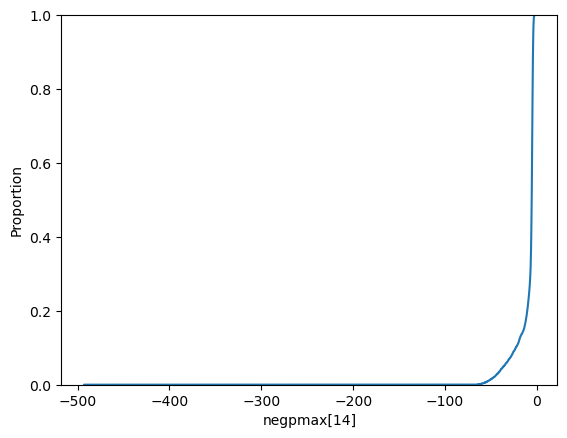

In [4]:
name_cols: list[str] = []
prefix = "pmax"
for i in range(18):
    name_cols.append(f"{prefix}[{i}]")

# dfm = dev_df.melt(
#     id_vars=["x", "y"],
#     var_name=f"{prefix}",
#     value_name="values",
#     value_vars=name_cols,
# )
# sns.ecdfplot(dfm, y="prefix", x="values", color=sns.color_palette()[0])

sns.ecdfplot(dev_df, x="negpmax[14]", color=sns.color_palette()[0])



C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


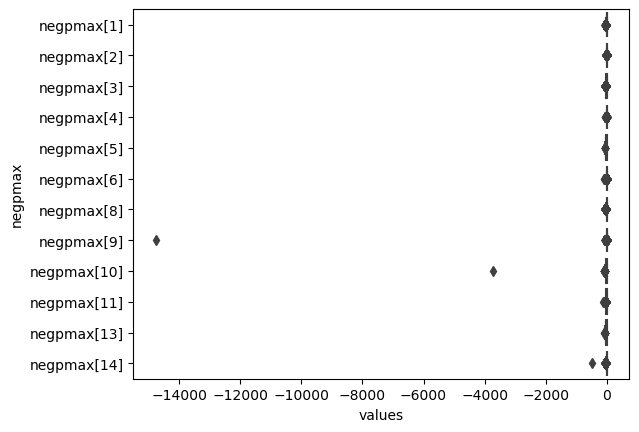

In [5]:
print()
prefix = "negpmax"
name_cols: list[str] = []
for i in [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14]:
    name_cols.append(f"{prefix}[{i}]")

dfm = dev_df.melt(
    id_vars=["x", "y"],
    var_name=f"{prefix}",
    value_name="values",
    value_vars=name_cols,
)
plot = sns.boxplot(dfm, y=f"{prefix}", x="values", color=sns.color_palette()[0])
# plt.gca().set(xlim=(-100, 0))

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='negpmax[8]', ylabel='Count'>

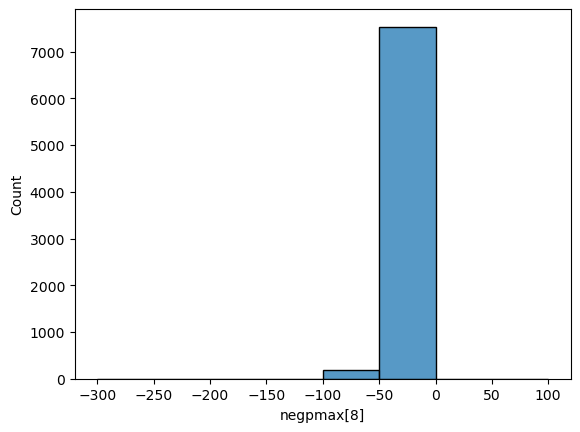

In [6]:
sns.histplot(dev_df, x="negpmax[8]", bins = [-300, -200, -150, -100, -50, 0, 100])

0.0


<Axes: >

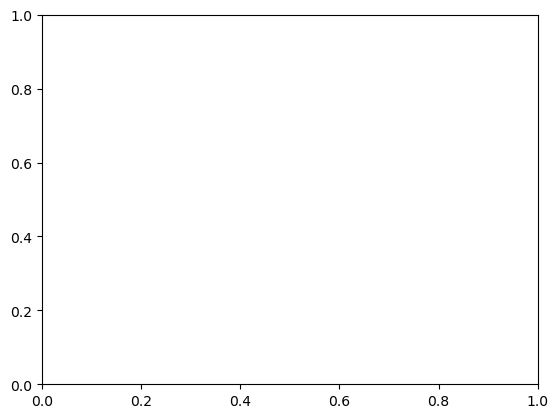

In [7]:

mask = (dev_df["negpmax[8]"]<-100) |  (dev_df["negpmax[8]"]>100)
print(mask.sum()/dev_df.shape[0]*100)
# sns.histplot(dev_df[mask], x="negpmax[8]", bins = [-90000, -300, -200, -150, -100])
sns.ecdfplot(dev_df[mask], x="negpmax[8]", color=sns.color_palette()[1])

In [31]:
col = 15
name_col = f"negpmax[{col}]"
df_plot = dev_df[["x", "y", name_col]]
mask = (df_plot[name_col]>=-300) & (df_plot[name_col]<=0)
df_plot = df_plot.loc[mask, :]
data_heatmap = (
    df_plot.groupby(["x", "y"])
    .mean()
    .reset_index()
    .sort_values(by=["x", "y"], ascending=[True, False])
    .pivot(index="y", columns="x", values=name_col)
    .sort_index(ascending=False)
)
fig, ax = plt.subplots(1, 1)
plot = sns.heatmap(
    data_heatmap,
    ax=ax,
    square=True,
    cbar_kws={"location": "right"},
)



def personalize_heatmap(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    title_colorbar: str,
    xlabel: str,
    ylabel: str,
) -> None:
    fig.set_size_inches(10, 8)

    color_bar = ax.collections[0].colorbar
    color_bar.ax.set_title(title_colorbar, fontsize=15)
    color_bar.ax.tick_params(axis="both", which="major", labelsize=13)
    color_bar.ax.tick_params(axis="both", which="minor", labelsize=13)
    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0)
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=20.0)
    col_labels = [int(col) for col in data_heatmap.columns]
    row_labels = [int(col) for col in data_heatmap.index]
    step = 10
    ax.set_xticks(
        np.arange(start=0.5, stop=data_heatmap.index.size, step=step),
        labels=col_labels[::step],
        fontsize=15,
    )
    ax.set_yticks(
        np.arange(start=0.5, stop=data_heatmap.index.size, step=step),
        labels=row_labels[::step],
        fontsize=15,
    )
    ax.tick_params(axis="x", labelrotation=0)

    plt.tight_layout()


personalize_heatmap(
    ax,
    fig,
    data_heatmap,
    title="Number of events per cell",
    title_colorbar="Number of events per cell",
    xlabel="X",
    ylabel="Y",
)



NameError: name 'dev_df' is not defined

In [4]:

def feature_extraction(dev_df: pd.DataFrame) -> None:
    col_pads_pmax = [f"pmax[{pad}]" for pad in COL_PADS]

    cols = ["x", "y"] + col_pads_pmax
    sorted_index = (-1 * (dev_df[col_pads_pmax].values)).argsort(axis=1)
    # only the first 3 are relevant
    sorted_index = sorted_index[:, :3]
    sorted_index_pd = pd.DataFrame(sorted_index)
    

    def combine_indexes(row: pd.Series):
        global max_num_triangle
        key = frozenset(COL_PADS[row.values])
        if key not in MAP_SET_PADS_TO_TRIANGLE:
            MAP_SET_PADS_TO_TRIANGLE[key] = max_num_triangle + 1
            max_num_triangle = max_num_triangle + 1

        return MAP_SET_PADS_TO_TRIANGLE[key]

    dev_df["triangle"] = sorted_index_pd.apply(combine_indexes, axis=1)
    if DEBUGGING:
        print((dev_df["triangle"] == pd.NA).sum())
        print(dev_df["triangle"])
        print(dev_df[col_pads_pmax].head())
        print(dev_df.tail(20))
        print(dev_df.shape)
        print(sorted_index.shape)
        print(dev_df["triangle"].unique())
    fig, ax = plt.subplots(1, 1)
    sns.scatterplot(
        dev_df, x="x", y="y", hue="triangle", palette="Set1", alpha=0.1, ax=ax
    )
    plt.show()
    fig, ax = plt.subplots(1, 1)
    sns.scatterplot(
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean(),
        x="x",
        y="y",
        hue="triangle",
        palette="Set1",
        ax=ax,
    )
    plt.show()
    triangle_to_xy = (
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean()
    )
    print("Percentage not starting triangles:")
    print((dev_df["triangle"]>14).sum() / dev_df["triangle"].size *100)
    print(sorted_index)
    
    sorted_values = -1*(np.sort(-1 * (dev_df[col_pads_pmax].values),axis=1))
    sorted_values = sorted_values[:, :3]
    print(np.mean(sorted_values, axis = 1))
    print(sorted_values)
    sns.histplot(x = np.mean(sorted_values, axis = 1)[dev_df["triangle"]>14], kde=True, stat="density", color =  sns.color_palette()[0])
    sns.histplot(x = np.mean(sorted_values, axis = 1)[dev_df["triangle"]<=14], kde=True, stat="density", color =  sns.color_palette()[0])
    plt.show()

    
    def get_x_triangle(row: pd.Series):
        return triangle_to_xy.loc[int(row["triangle"]), :]["x"]

    def get_y_triangle(row: pd.Series):
        return triangle_to_xy.loc[int(row["triangle"]), :]["x"]

    dev_df["x_triag"] = dev_df.apply(get_x_triangle, axis=1)
    dev_df["y_triag"] = dev_df.apply(get_y_triangle, axis=1)
    print(dev_df.head())
    print(sorted_index)


In [6]:
def feature_extraction_2(dev_df: pd.DataFrame) -> None:
    col_pads_pmax = [f"pmax[{pad}]" for pad in COL_PADS]

    cols = ["x", "y"] + col_pads_pmax
    

    def define_triangle(row: pd.Series):
        max_val = 0
        key_max = frozenset([6, 5, 4])
        for key in MAP_SET_PADS_TO_TRIANGLE:
            cols_to_select = [f"pmax[{pas}]" for pas in key]
            val = row[cols_to_select].mean()
            if val > max_val:
                max_val = val
                key_max = key
        
        return MAP_SET_PADS_TO_TRIANGLE[key_max]

    dev_df["triangle"] = dev_df[cols].apply(define_triangle, axis=1)
    if True:
        print((dev_df["triangle"] == pd.NA).sum())
        print(dev_df["triangle"])
        print(dev_df[col_pads_pmax].head())
        print(dev_df.tail(20))
        print(dev_df.shape)
        print(dev_df["triangle"].unique())
    fig, ax = plt.subplots(1, 1)
    sns.scatterplot(
        dev_df, x="x", y="y", hue="triangle", palette="Set1", alpha=0.1, ax=ax
    )
    plt.show()
    fig, ax = plt.subplots(1, 1)
    sns.scatterplot(
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean(),
        x="x",
        y="y",
        hue="triangle",
        palette="Set1",
        ax=ax,
    )
    plt.show()
    triangle_to_xy = (
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean()
    )
    print("Percentage not starting triangles:")
    print((dev_df["triangle"]>14).sum() / dev_df["triangle"].size *100)
    
    sorted_values = -1*(np.sort(-1 * (dev_df[col_pads_pmax].values),axis=1))
    sorted_values = sorted_values[:, :3]
    print(np.mean(sorted_values, axis = 1))
    print(sorted_values)
    sns.histplot(x = np.mean(sorted_values, axis = 1)[dev_df["triangle"]>14], kde=True, stat="density", color =  sns.color_palette()[0])
    sns.histplot(x = np.mean(sorted_values, axis = 1)[dev_df["triangle"]<=14], kde=True, stat="density", color =  sns.color_palette()[0])
    plt.show()

    
    def get_x_triangle(row: pd.Series):
        return triangle_to_xy.loc[int(row["triangle"]), :]["x"]

    def get_y_triangle(row: pd.Series):
        return triangle_to_xy.loc[int(row["triangle"]), :]["x"]

    dev_df["x_triag"] = dev_df.apply(get_x_triangle, axis=1)
    dev_df["y_triag"] = dev_df.apply(get_y_triangle, axis=1)
    print(dev_df.head())


0
0         11
1         11
2         11
3         11
4         11
          ..
385495     4
385496     4
385497     4
385498     4
385499     4
Name: triangle, Length: 385500, dtype: int64
    pmax[1]   pmax[2]   pmax[3]   pmax[4]    pmax[5]   pmax[6]    pmax[8]  \
0  5.409161  6.084506  3.811328  4.893027   9.322305  3.077338  26.581253   
1  4.414289  4.507257  3.940369  5.549379   9.373914  5.424356  27.797015   
2  4.567191  5.384155  4.903412  3.795407   7.499896  5.846233  23.163651   
3  5.019058  4.165598  3.791672  4.848719  10.422260  5.157927  26.592899   
4  3.250262  4.736023  5.123048  3.026709  12.557806  6.115046  25.261710   

      pmax[9]   pmax[10]   pmax[11]   pmax[13]   pmax[14]  
0   99.361264  42.068393  12.438458   7.454877   6.611877  
1   96.062561  38.690210  12.326212  18.472514  13.802252  
2   93.767398  40.337067   9.253250   7.336668   5.940039  
3   89.620438  37.796774  10.900876   8.450671   6.434910  
4  106.109430  42.202023  13.956659   8.721952 

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

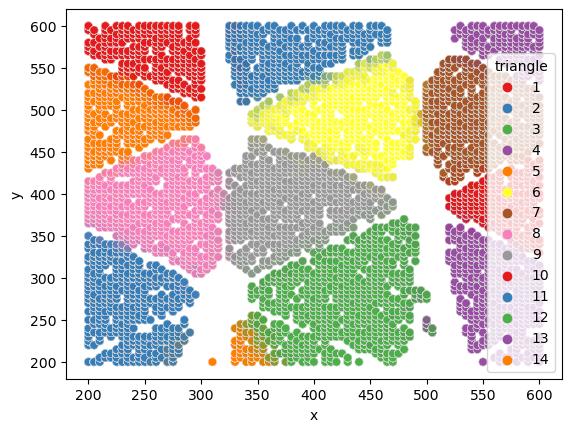

C:\Users\cucch\AppData\Local\Temp\ipykernel_8304\174978419.py:35: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categori

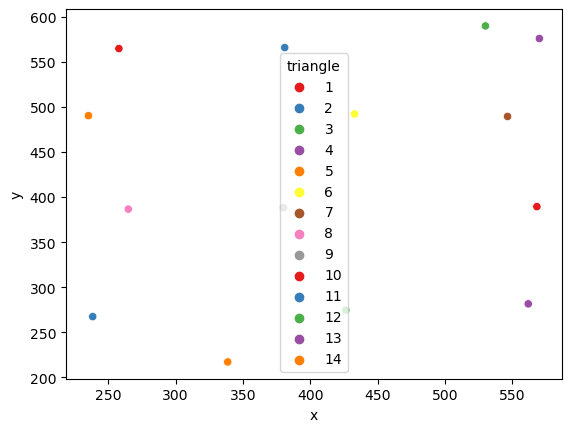

C:\Users\cucch\AppData\Local\Temp\ipykernel_8304\174978419.py:49: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Percentage not starting triangles:
0.0
[56.00363668 54.18326213 52.42270508 ... 60.78395793 51.85525411
 59.37123006]
[[99.36126404 42.06839294 26.58125305]
 [96.06256104 38.69020996 27.79701538]
 [93.76739807 40.33706665 23.16365051]
 ...
 [73.8500885  61.84010315 46.66168213]
 [59.27792664 49.77207031 46.51576538]
 [64.35132446 59.77421875 53.98814697]]


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


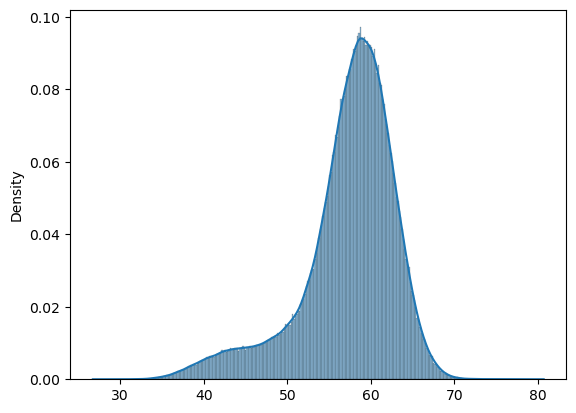

       x      y   pmax[0]  negpmax[0]   area[0]     tmax[0]    rms[0]  \
0  200.0  200.0  4.066907  -17.690173  2.847932    0.600000  2.007042   
1  200.0  200.0  5.916801   -4.717111  5.792778   79.765174  1.564535   
2  200.0  200.0  4.286652   -5.316132  2.356390   74.600000  1.404622   
3  200.0  200.0  4.003635   -4.617459  2.189005   43.000000  1.512162   
4  200.0  200.0  4.448146   -4.848743  3.997002  196.667482  1.101113   

    pmax[1]  negpmax[1]   area[1]  ...   tmax[16]   rms[16]    pmax[17]  \
0  5.409161  -17.721210  4.538778  ...  72.373094  0.374498  614.916861   
1  4.414289   -4.736827  3.720435  ...  71.029155  0.403258  624.950701   
2  4.567191   -5.985437  3.490490  ...  71.892264  0.568777  596.437125   
3  5.019058   -4.229949  6.786200  ...  72.357388  0.255483  591.763739   
4  3.250262   -5.783587  2.449456  ...  71.249130  0.413855  606.917023   

   negpmax[17]    area[17]   tmax[17]   rms[17]  triangle    x_triag  \
0   -39.848523  591.852768  72.331028 

In [7]:
feature_extraction_2(dev_df)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    dev_df.drop(["x", "y"], axis=1), dev_df[["x", "y"]], train_size=0.8, shuffle=True
)

regr = RandomForestRegressor(random_state=42, max_features="sqrt")

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

In [ ]:
def personalize_barplot(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    width_inches: int = 12,
    height_inches: int = 8,
) -> None:
    fig.set_size_inches(width_inches, height_inches)

    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20,
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0, position="right")
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=70.0, position="top")
    ax.tick_params(axis="x", labelsize=15,)
    ax.tick_params(axis="y", labelsize=15,)
    plt.tight_layout()




def analyse_feature_importante(
    forest: RandomForestRegressor, features_names: list[str]
):
    # TODO: Check the function
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    
    
    feature_import_df = pd.DataFrame(
        {
            "feature": features_names,
            "importance": importances,
        }
    )
    feature_import_df = feature_import_df.sort_values("importance", ascending=False)
    
    # groupying by type of feature
    feature_cat_import_df = pd.DataFrame(
        {
            "feature": [re.sub(r"\[\d+\]", "", feat) for feat in features_names],
            "importance": importances,
        }
    )
    feature_cat_import_df = feature_cat_import_df.groupby("feature", as_index=False).sum().sort_values("importance", ascending = False)
    print(feature_cat_import_df)
    feature_import_df["std"] = std
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    plt.grid()
    sns.barplot(feature_cat_import_df, y="feature", x="importance", color=sns.color_palette()[0])
    personalize_barplot(
        ax,
        fig,
        feature_cat_import_df,
        "Feature importance by category",
        "Importance",
        "Feature category",
    )
    plt.show()    
    plt.clf()
    fig, ax = plt.subplots(1, 1)
    plt.grid()
    sns.barplot(feature_import_df, y="feature", x="importance", color=sns.color_palette()[0])
    personalize_barplot(
        ax,
        fig,
        feature_import_df,
        "Feature importance",
        "Importance",
        "Feature",
        12,
        18
    )
    plt.show()    
    plt.clf()
    
    

analyse_feature_importante(
    regr, list(dev_df.drop(["x", "y"], axis=1).columns)
)
dev_df.head()

In [ ]:
def personalize_histplot(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    width_inches: int = 12,
    height_inches: int = 8,
) -> None:
    fig.set_size_inches(width_inches, height_inches)

    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20,
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0, position="right")
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=70.0, position="top")
    ax.tick_params(axis="x", labelsize=15,)
    ax.tick_params(axis="y", labelsize=15,)
    ax.lines[0].set_color(sns.color_palette()[1])
    plt.tight_layout()



plt.clf()
fig, ax = plt.subplots(1, 1)
plot = sns.histplot(dev_df, x="pmax[1]", kde=True, stat="density", color =  sns.color_palette()[0])
personalize_histplot(
    ax,
    fig,
    dev_df,
    "Distribution pmax[1]",
    f"pmax[1] [{UNIT_OF_MEASURE_COL['pmax']}]",
    "Density",
)
plt.show() 

In [ ]:
def personalize_boxplot(
    ax,
    fig,
    data_heatmap: pd.DataFrame,
    title: str,
    xlabel: str,
    ylabel: str,
    width_inches: int = 12,
    height_inches: int = 8,
) -> None:
    fig.set_size_inches(width_inches, height_inches)

    ax.set_title(
        title,
        fontdict={
            "fontsize": 24,
            "horizontalalignment": "center",
        },
        pad=20,
    )

    ax.set_xlabel(xlabel, fontsize=18, labelpad=8.0, position="right")
    ax.set_ylabel(ylabel, rotation=0, fontsize=18, labelpad=70.0, position="top")
    ax.tick_params(axis="x", labelsize=15,)
    ax.tick_params(axis="y", labelsize=15,)
    plt.tight_layout()



name_cols = [f"pmax[{i}]" for i in range(18)]
dfm = dev_df.melt(
    id_vars=["x", "y"],
    var_name=f"pmax",
    value_name="values",
    value_vars=name_cols,
)
plt.clf()
fig, ax = plt.subplots(1, 1)
sns.boxplot(dfm, y=f"pmax", x="values", color=sns.color_palette()[0])
personalize_boxplot(
    ax,
    fig,
    dev_df,
    "Pmax distributions",
    "Distribution",
    "Feature",
    13, 9
)
plt.show()

In [8]:
def feature_selection(data: pd.DataFrame, is_dev: bool = True) -> pd.DataFrame:
    cols = []
    if is_dev:
        cols += ["x", "y"]
    pads_to_keep = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14]
    # TODO: check if keeping tmax the results improve
    type_of_columns = ["negpmax", "pmax", "area"]
    cols += [f"{type}[{i}]" for i in pads_to_keep for type in type_of_columns]
    cols += ["pmax[15]"]
    return data[cols]



dev_df_sel = feature_selection(dev_df)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    dev_df_sel.drop(["x", "y"], axis=1), dev_df_sel[["x", "y"]], train_size=0.8, shuffle=True
)

svr_regr = make_pipeline(StandardScaler(), PCA(0.8, random_state=42), SVR())
regr = MultiOutputRegressor(svr_regr)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

NameError: name 'dev_df_sel' is not defined

In [14]:
dev_df.head()

,x,y,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],...,tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17],triangle,x_triag,y_triag
0,200.0,200.0,4.066907,-17.690173,2.847932,0.600000,2.007042,5.409161,-17.721210,4.538778,...,72.373094,0.374498,614.916861,-39.848523,591.852768,72.331028,0.405595,11,238.50613,238.50613
1,200.0,200.0,5.916801,-4.717111,5.792778,79.765174,1.564535,4.414289,-4.736827,3.720435,...,71.029155,0.403258,624.950701,-41.266681,586.569646,71.089058,0.405890,11,238.50613,238.50613
2,200.0,200.0,4.286652,-5.316132,2.356390,74.600000,1.404622,4.567191,-5.985437,3.490490,...,71.892264,0.568777,596.437125,-42.712286,574.091695,71.943934,0.498019,11,238.50613,238.50613
3,200.0,200.0,4.003635,-4.617459,2.189005,43.000000,1.512162,5.019058,-4.229949,6.786200,...,72.357388,0.255483,591.763739,-50.681940,584.099483,72.333282,0.336454,11,238.50613,238.50613
4,200.0,200.0,4.448146,-4.848743,3.997002,196.667482,1.101113,3.250262,-5.783587,2.449456,...,71.249130,0.413855,606.917023,-49.923819,584.316142,71.242904,0.293824,11,238.50613,238.50613


In [16]:
dev_df.to_csv("./development_triangle.csv", index=False)

In [17]:
dev_df_sel = feature_selection(dev_df)
dev_df_sel.to_csv("./development_processed.csv", index=False)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    dev_df_sel.drop(["x", "y"], axis=1), dev_df_sel[["x", "y"]], train_size=0.8, shuffle=True
)

svr_regr = make_pipeline(StandardScaler(), PCA(0.8, random_state=42), SVR())
regr = MultiOutputRegressor(svr_regr)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

In [13]:
dev_df_proc = pd.read_csv("./development_processed.csv", header=0, index_col=False)
dev_df_triag = pd.read_csv("./development_triangle.csv", header = 0, index_col = False)

eval_df_processed = pd.read_csv("./evaluation_processed.csv", header = 0, index_col = False)
eval_df = pd.read_csv("./evaluation.csv", header = 0, index_col = False)

In [14]:
print(dev_df_proc.shape)
print(dev_df_triag.shape)
dev_df_triag.columns
dev_df_proc.index
print((dev_df_proc["negpmax[1]"]-dev_df_triag["negpmax[1]"]).sum())
dev_df_proc["triangle"] =  dev_df_triag["triangle"]
dev_df_proc["x_triag"] =  dev_df_triag["x_triag"]
dev_df_proc["y_triag"] =  dev_df_triag["y_triag"]
dev_df_proc.head()

dev_df_proc["maxpmax"] = dev_df_proc[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)
eval_df_processed["maxpmax"] = eval_df_processed[['pmax[1]', 'pmax[2]', 'pmax[3]', 'pmax[4]','pmax[5]','pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]','pmax[15]']].max(axis = 1)

eval_df_processed.drop(["triangle"], inplace=True, axis = 1)
dev_df_proc.drop(["triangle"], inplace=True, axis = 1)

(385500, 39)
(385500, 95)
0.0


In [44]:
# check that the order of the two is the same
print((eval_df_processed["negpmax[1]"] - eval_df["negpmax[1]"]).sum())
print(eval_df_processed.columns)
print(dev_df_proc.drop(["x", "y"], axis = 1).columns)

0.0
Index(['negpmax[1]', 'pmax[1]', 'area[1]', 'negpmax[2]', 'pmax[2]', 'area[2]',
       'negpmax[3]', 'pmax[3]', 'area[3]', 'negpmax[4]', 'pmax[4]', 'area[4]',
       'negpmax[5]', 'pmax[5]', 'area[5]', 'negpmax[6]', 'pmax[6]', 'area[6]',
       'negpmax[8]', 'pmax[8]', 'area[8]', 'negpmax[9]', 'pmax[9]', 'area[9]',
       'negpmax[10]', 'pmax[10]', 'area[10]', 'negpmax[11]', 'pmax[11]',
       'area[11]', 'negpmax[13]', 'pmax[13]', 'area[13]', 'negpmax[14]',
       'pmax[14]', 'area[14]', 'pmax[15]', 'x_triag', 'y_triag', 'maxpmax'],
      dtype='object')
Index(['negpmax[1]', 'pmax[1]', 'area[1]', 'negpmax[2]', 'pmax[2]', 'area[2]',
       'negpmax[3]', 'pmax[3]', 'area[3]', 'negpmax[4]', 'pmax[4]', 'area[4]',
       'negpmax[5]', 'pmax[5]', 'area[5]', 'negpmax[6]', 'pmax[6]', 'area[6]',
       'negpmax[8]', 'pmax[8]', 'area[8]', 'negpmax[9]', 'pmax[9]', 'area[9]',
       'negpmax[10]', 'pmax[10]', 'area[10]', 'negpmax[11]', 'pmax[11]',
       'area[11]', 'negpmax[13]', 'pmax[13]', 

0          77.823996
1         120.084433
2         107.393882
3         115.156488
4          97.055603
             ...    
128495    119.568432
128496    117.282706
128497    115.297141
128498    112.906531
128499    123.507799
Name: maxpmax, Length: 128500, dtype: float64

In [43]:
print(eval_df_processed.index)
print(dev_df_proc.columns)

RangeIndex(start=0, stop=128500, step=1)
Index(['x', 'y', 'negpmax[1]', 'pmax[1]', 'area[1]', 'negpmax[2]', 'pmax[2]',
       'area[2]', 'negpmax[3]', 'pmax[3]', 'area[3]', 'negpmax[4]', 'pmax[4]',
       'area[4]', 'negpmax[5]', 'pmax[5]', 'area[5]', 'negpmax[6]', 'pmax[6]',
       'area[6]', 'negpmax[8]', 'pmax[8]', 'area[8]', 'negpmax[9]', 'pmax[9]',
       'area[9]', 'negpmax[10]', 'pmax[10]', 'area[10]', 'negpmax[11]',
       'pmax[11]', 'area[11]', 'negpmax[13]', 'pmax[13]', 'area[13]',
       'negpmax[14]', 'pmax[14]', 'area[14]', 'pmax[15]', 'x_triag', 'y_triag',
       'maxpmax'],
      dtype='object')


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    dev_df_proc.drop(["x", "y", "triangle"], axis=1), dev_df_proc[["x", "y"]], train_size=0.5, shuffle=True
)

start_time = datetime.datetime.now().replace(microsecond=0)
regr = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

KeyboardInterrupt: 

In [45]:
# for the submission
X = dev_df_proc.drop(["x", "y"], axis = 1)
y = dev_df_proc[["x", "y"]]


start_time = datetime.datetime.now().replace(microsecond=0)
regr = RandomForestRegressor(random_state=42, n_estimators=100, criterion="squared_error", max_features="sqrt", max_depth=None)

regr.fit(X, y)
regr_final = regr

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

In [46]:
eval_results = pd.DataFrame()
y_pred = regr.predict(eval_df_processed)
eval_results["x"] = y_pred[:, 0]
eval_results["y"] = y_pred[:, 1]
eval_results["Predicted"] = eval_results.agg('{0[x]}|{0[y]}'.format, axis=1)

end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)
eval_results["Id"] = eval_df_processed.index
eval_results.to_csv("./submission.csv", columns = ["Id", "Predicted"], index=False)

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Time for the computations:
0:09:50


In [ ]:
y_pred = regr.predict(X)
med = (
    np.sqrt(np.sum(np.power(y - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

In [ ]:
X = dev_df_proc.drop(["x", "y"], axis = 1)
y = dev_df_proc[["x", "y"]]
filename = 'model_submission.sav'
#pickle.dump(regr, open(filename, 'wb'))

test_load = pickle.load(open(filename, 'rb'))

In [21]:
y_pred = test_load.predict(X)
med = (
    np.sqrt(np.sum(np.power(y - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

print(dir(test_load))
print(test_load.feature_importances_)
print(X.columns)

C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1.5877687716239905
['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_feature_names', '_check_n_features', '_compute_oob_predictions', '_compute_partial_dependence_recursion', '_estimator_type', '_get_oob_predictions', '_get_param_names', '_get_tags', '_make_estimator', '_more_tags', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_set_oob_score_and_attributes', '_validate_X_predict', '_validate_data', '_validate_estimator', '_validate_params', '_validate_y_class_weight', 'apply', 'base_estimator', 'base_esti

In [15]:
pca= PCA(0.95, random_state=42)
scal_output = StandardScaler()
scal = StandardScaler()
output_dev = dev_df_proc[["x", "y"]]
print(dev_df_proc.columns)
input_dev = dev_df_proc.drop(["x", "y", "triangle"], axis=1)
output_dev_scaled = scal_output.fit_transform(output_dev)
input_dev = scal.fit_transform(input_dev)
pca.fit(input_dev)
print(pca.explained_variance_ratio_)

Index(['x', 'y', 'negpmax[1]', 'pmax[1]', 'area[1]', 'negpmax[2]', 'pmax[2]',
       'area[2]', 'negpmax[3]', 'pmax[3]', 'area[3]', 'negpmax[4]', 'pmax[4]',
       'area[4]', 'negpmax[5]', 'pmax[5]', 'area[5]', 'negpmax[6]', 'pmax[6]',
       'area[6]', 'negpmax[8]', 'pmax[8]', 'area[8]', 'negpmax[9]', 'pmax[9]',
       'area[9]', 'negpmax[10]', 'pmax[10]', 'area[10]', 'negpmax[11]',
       'pmax[11]', 'area[11]', 'negpmax[13]', 'pmax[13]', 'area[13]',
       'negpmax[14]', 'pmax[14]', 'area[14]', 'pmax[15]', 'triangle',
       'x_triag', 'y_triag'],
      dtype='object')


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be

[0.24977821 0.17944084 0.08276343 0.05694963 0.03851184 0.02724093
 0.02642614 0.02563721 0.02563107 0.0255224  0.02547063 0.02522654
 0.0250479  0.02435458 0.0237455  0.0222659  0.0190339  0.01780123
 0.01505585 0.01220611 0.01111311]


In [ ]:
input_dev_pca = pca.transform(input_dev)

start_time = datetime.datetime.now().replace(microsecond=0)
X_train, X_val, y_train, y_val = train_test_split(
    input_dev, output_dev_scaled, train_size=0.01, shuffle=True
)

svr_regr = SVR()
regr = MultiOutputRegressor(svr_regr)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

y_pred = scal_output.inverse_transform(y_pred)
y_val = scal_output.inverse_transform(y_val)
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)
end_time = datetime.datetime.now().replace(microsecond=0)
print("Time for the computations:")
print(end_time-start_time)

In [17]:
# gives worse results than with scaling also the outputs
X_train, X_val, y_train, y_val = train_test_split(
    input_dev_pca, output_dev, train_size=0.02, shuffle=True
)

svr_regr = SVR()
regr = MultiOutputRegressor(svr_regr)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med)

9.71847486640346


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


15.16185956939415


In [18]:

y_pred = scal_output.inverse_transform(y_pred)
y_val = scal_output.inverse_transform(y_val)
med = (
    np.sqrt(np.sum(np.power(y_val - y_pred, 2), axis=1)).sum() / y_pred.shape[0]
)
print(med

1771.0585370462434
0:00:00


C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\cucch\miniconda3\envs\DataScienceLab\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [28]:
# Check the two triangle generation function

def generate_triangles_position_and_apply(
    dev_df: pd.DataFrame,
) -> dict[int, list[float]]:
    col_pads_pmax = [f"pmax[{pad}]" for pad in COL_PADS]

    cols = ["x", "y"] + col_pads_pmax

    dev_df["triangle"] = dev_df[cols].apply(define_triangle, axis=1)
    triangle_to_xy = (
        dev_df[["triangle", "x", "y"]]
        .groupby(
            "triangle",
            axis=0,
        )
        .mean()
    )

    triangle_to_xy_dict = {
        triangle: [
            triangle_to_xy.loc[triangle, :]["x"],
            triangle_to_xy.loc[triangle, :]["y"],
        ]
        for triangle in list(triangle_to_xy.index)
    }

    dev_df["x_triag"] = dev_df.apply(
        lambda x: get_x_triangle(x, triangle_to_xy_dict), axis=1
    )
    dev_df["y_triag"] = dev_df.apply(
        lambda x: get_y_triangle(x, triangle_to_xy_dict), axis=1
    )
    return triangle_to_xy_dict


def feature_extraction(
    data: pd.DataFrame, triangle_to_xy: dict[int, list[float]]
) -> None:
    cols = [f"pmax[{pad}]" for pad in COL_PADS]
    data["triangle"] = data[cols].apply(define_triangle, axis=1)
    print("Unique triangles eval:")
    print(np.unique(data["triangle"]))
    data["x_triag"] = data.apply(lambda x: get_x_triangle(x, triangle_to_xy), axis=1)
    data["y_triag"] = data.apply(lambda x: get_y_triangle(x, triangle_to_xy), axis=1)


def define_triangle(row: pd.Series):
    max_val = 0
    key_max = frozenset([6, 5, 4])
    for key in MAP_SET_PADS_TO_TRIANGLE:
        cols_to_select = [f"pmax[{pas}]" for pas in key]
        val = row[cols_to_select].mean()
        if val > max_val:
            max_val = val
            key_max = key

    return MAP_SET_PADS_TO_TRIANGLE[key_max]


def get_x_triangle(row: pd.Series, triangle_to_xy_dict: dict[int, list[float]]):
    return triangle_to_xy_dict[int(row["triangle"])][0]


def get_y_triangle(row: pd.Series, triangle_to_xy_dict: dict[int, list[float]]):
    return triangle_to_xy_dict[int(row["triangle"])][1]



triangle_to_xy: dict[int, list[float]] = generate_triangles_position_and_apply(
   dev_df_sample
)
print(triangle_to_xy)
feature_extraction(dev_df_sample_test, triangle_to_xy)
dev_df_sample_test["triangle"]
feature_extraction(eval_df_processed_sample, triangle_to_xy)
eval_df_processed_sample

C:\Users\cucch\AppData\Local\Temp\ipykernel_17712\3573166813.py:13: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  .groupby(


{1: [257.4264705882353, 565.0], 2: [380.76785714285717, 564.7857142857143], 4: [569.3965517241379, 575.2155172413793], 5: [235.8675799086758, 491.00456621004565], 6: [433.54755784061695, 492.36503856041134], 7: [546.3802816901408, 489.0422535211268], 8: [264.7624703087886, 386.8289786223278], 9: [380.0, 388.015873015873], 10: [567.8804347826087, 388.5869565217391], 11: [238.5518292682927, 267.2865853658537], 12: [426.7204301075269, 274.17562724014334], 13: [561.5634674922601, 281.28482972136226], 14: [337.8378378378378, 217.56756756756758]}
Unique triangles eval:
[ 1  2  4  5  6  7  8  9 10 11 12 13 14]
Unique triangles eval:
[7 8]


,negpmax[1],pmax[1],area[1],negpmax[2],pmax[2],area[2],negpmax[3],pmax[3],area[3],negpmax[4],...,negpmax[13],pmax[13],area[13],negpmax[14],pmax[14],area[14],pmax[15],triangle,x_triag,y_triag
1,-20.616669,23.460358,17.998419,-20.351328,20.116995,11.315171,-57.040155,95.746893,47.867699,-9.163229,...,-10.732013,23.587567,14.635765,-6.347998,10.272607,6.507688,120.084433,7,546.380282,489.042254
2,-7.224267,4.837952,3.289124,-4.086172,6.132150,3.578799,-5.478476,7.510110,5.374246,-6.361444,...,-4.244329,12.934276,11.301154,-5.449399,3.556735,3.488582,107.393882,8,264.762470,386.828979


In [26]:
dev_df_proc = pd.read_csv("./development_processed.csv", header=0, index_col=False)
dev_df_triag = pd.read_csv("./development_triangle.csv", header = 0, index_col = False)

eval_df_processed = pd.read_csv("./evaluation_processed.csv", header = 0, index_col = False)
eval_df = pd.read_csv("./evaluation.csv", header = 0, index_col = False)

In [27]:
dev_df_proc.head()
dev_df_sample = dev_df_proc.iloc[0::100, :].copy()
dev_df_sample_test = dev_df_proc.iloc[1::100, :].copy()
eval_df_processed_sample = eval_df_processed.iloc[1:3, :].copy()
dev_df_sample.head()

,x,y,negpmax[1],pmax[1],area[1],negpmax[2],pmax[2],area[2],negpmax[3],pmax[3],...,negpmax[11],pmax[11],area[11],negpmax[13],pmax[13],area[13],negpmax[14],pmax[14],area[14],pmax[15]
0,200.0,200.0,-17.721210,5.409161,4.538778,-19.892543,6.084506,3.132328,-23.747293,3.811328,...,-18.148151,12.438458,7.611376,-16.861163,7.454877,4.191909,-17.685799,6.611877,4.884680,149.648736
100,200.0,220.0,-5.380579,5.091223,4.139687,-5.733804,3.191306,1.521970,-3.199762,5.746016,...,-5.705574,9.466507,4.561102,-4.555315,5.817816,2.212823,-4.538379,4.891064,3.176260,119.895911
200,200.0,225.0,-4.556509,4.861826,4.533303,-4.390100,4.548071,2.720283,-4.111963,4.900665,...,-6.861099,10.871628,6.576874,-4.896539,7.053839,6.534794,-4.744656,5.174684,2.342492,131.835562
300,200.0,230.0,-4.124747,6.548837,3.953820,-3.908534,4.547089,2.808374,-3.820050,6.060443,...,-5.300330,10.965723,6.698665,-4.307922,10.724432,6.678181,-4.453057,5.556094,3.307987,144.729876
400,200.0,235.0,-6.061582,5.124353,3.369883,-5.987332,4.541782,2.202445,-3.303766,6.373783,...,-4.374991,10.817209,7.228931,-4.733496,12.796799,8.114011,-5.840768,3.888358,1.438663,146.230122


In [37]:
col = [f"pmax[{i}]" for i in COL_PADS]

print(triangle_to_xy)
eval_df_processed_sample

{1: [257.4264705882353, 565.0], 2: [380.76785714285717, 564.7857142857143], 4: [569.3965517241379, 575.2155172413793], 5: [235.8675799086758, 491.00456621004565], 6: [433.54755784061695, 492.36503856041134], 7: [546.3802816901408, 489.0422535211268], 8: [264.7624703087886, 386.8289786223278], 9: [380.0, 388.015873015873], 10: [567.8804347826087, 388.5869565217391], 11: [238.5518292682927, 267.2865853658537], 12: [426.7204301075269, 274.17562724014334], 13: [561.5634674922601, 281.28482972136226], 14: [337.8378378378378, 217.56756756756758]}


,negpmax[1],pmax[1],area[1],negpmax[2],pmax[2],area[2],negpmax[3],pmax[3],area[3],negpmax[4],...,negpmax[13],pmax[13],area[13],negpmax[14],pmax[14],area[14],pmax[15],triangle,x_triag,y_triag
1,-20.616669,23.460358,17.998419,-20.351328,20.116995,11.315171,-57.040155,95.746893,47.867699,-9.163229,...,-10.732013,23.587567,14.635765,-6.347998,10.272607,6.507688,120.084433,7,546.380282,489.042254
2,-7.224267,4.837952,3.289124,-4.086172,6.132150,3.578799,-5.478476,7.510110,5.374246,-6.361444,...,-4.244329,12.934276,11.301154,-5.449399,3.556735,3.488582,107.393882,8,264.762470,386.828979
